In [1]:
# Colab was used for this notebook hence the library installs
%%capture
!pip install pycaret --quiet --upgrade
!pip install dabl --quiet --upgrade
!pip install shap --quiet --upgrade
!pip install sdv  --quiet --upgrade
!pip install sdv[ctgan] --quiet --upgrade
!pip install baytune --quiet --upgrade
!pip install optuna --quiet --upgrade

UsageError: Line magic function `%%capture` not found.


## **Why this was done**
1. Learn about synthetic data generation and see if it can improve a model
2. Work with PyCaret on a classification problem
3. Work on an insurance related problem (although ficticious data)
4. Build a `streamlit` app

## **The data**
HR data isn't easy to find given the nature of the data. However IBM has created [fictious data](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) around whether an employee left after 6 months which can be used. The features for each employee are...

* ` age `
* ` bmi `
* ` children `
* ` sex `
* ` smoker `
* ` region `


# **Libraries**

In [1]:
from pycaret.classification import * 
#from pycaret.regression import * # Preprocessing, modelling, interpretation, deployment...
from sklearn.impute import SimpleImputer
import pandas as pd # Basic data manipulation
#import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN, GaussianCopula, CTGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
#from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
#from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps
import sdv.constraints as cons # Evaluate synthetic data

# **Importing data**

In [2]:
# Read and output the top 5 rows
ins_data = pd.read_csv("insurance.csv")
ins_data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


156


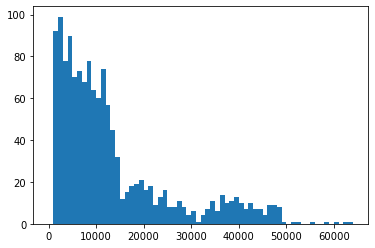

In [3]:
ins_data = pd.read_csv("insurance.csv")
from matplotlib import pyplot as plt
plt.hist(ins_data['charges'], bins=[1000*i for i in range (65)])
ins_data['charges'].describe()
def transform(x):
    if x<5000: return 0 # First"Peak"
    if x<16000: return 1 # Second Peak
    if x<31000: return 2 # Thrid Peak
    return 3
print(len(ins_data[ins_data["charges"]>31000]))
ins_data["charges"]=ins_data["charges"].map(transform)

A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [4]:
# Target feature
target = "charges"

# Continuous/numeric features
cont_feats = ["age", "bmi"]

# Ordinal features
ord_feats = {"children" : ["0", "1", "2", "3", "4", "5"]}

# Categorical geatures
cat_feats = ["region", "smoker", "sex"]

# There is a value error for children:
# ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than.


In [5]:
# Split real data into training + test set
train, test, target_train, target_test = train_test_split(ins_data.drop("charges", axis = 1), ins_data["charges"], test_size = 0.4, random_state = 42)

# Add Attrition column back into training + test set
train["charges"] = target_train
test["charges"] = target_test

In [6]:
# Run pycaret setup
setup(data = train, 
      target = target, 
      test_data = test,
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True,
      verbose = False)

(       age        bmi  children  sex_female  smoker_no  region_northeast  \
 25    59.0  27.719999       3.0         1.0        1.0               0.0   
 336   60.0  25.740000       0.0         0.0        1.0               0.0   
 47    28.0  34.770000       0.0         1.0        1.0               0.0   
 106   19.0  28.400000       1.0         1.0        1.0               0.0   
 1269  45.0  27.500000       3.0         0.0        1.0               0.0   
 ...    ...        ...       ...         ...        ...               ...   
 1095  18.0  31.350000       4.0         1.0        1.0               1.0   
 1130  39.0  23.870001       5.0         1.0        1.0               0.0   
 1294  58.0  25.174999       0.0         0.0        1.0               1.0   
 860   37.0  47.599998       2.0         1.0        0.0               0.0   
 1126  55.0  29.900000       0.0         0.0        1.0               0.0   
 
       region_northwest  region_southeast  region_southwest  
 25         

Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months. Cross validation is also used.

In [7]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8715,0.9327,0.8354,0.8734,0.8660,0.8054,0.8089,0.1140
rf,Random Forest Classifier,0.8703,0.9359,0.8378,0.8738,0.8657,0.8042,0.8078,0.1360
lr,Logistic Regression,0.8641,0.9184,0.8133,0.8678,0.8563,0.7924,0.7979,0.6450
lightgbm,Light Gradient Boosting Machine,0.8641,0.9339,0.8289,0.8659,0.8587,0.7950,0.7982,0.0960
ridge,Ridge Classifier,0.8504,0.0000,0.7909,0.8600,0.8322,0.7723,0.7804,0.0130
lda,Linear Discriminant Analysis,0.8392,0.9222,0.7714,0.8444,0.8131,0.7560,0.7664,0.0140
et,Extra Trees Classifier,0.8329,0.9293,0.7979,0.8350,0.8309,0.7484,0.7508,0.1340
dt,Decision Tree Classifier,0.8068,0.8593,0.7936,0.8170,0.8076,0.7137,0.7165,0.0120
ada,Ada Boost Classifier,0.7619,0.8576,0.6504,0.6943,0.7176,0.6379,0.6526,0.0340
nb,Naive Bayes,0.7443,0.9201,0.7422,0.7894,0.7368,0.6294,0.6525,0.0140


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=7902, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

So `Logistic Regression` is looking promising for `AUC` but `Recall` is not high, regardless I'll build a model on this. As shown below each fold's metrics are shown and the average from them.

In [8]:
rf = create_model("rf") # Create logistic regression model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9012,0.9787,0.8920,0.8992,0.8999,0.8524,0.8526
1,0.8272,0.9219,0.8201,0.8263,0.8264,0.7433,0.7435
2,0.8500,0.9267,0.8106,0.8431,0.8394,0.7720,0.7757
3,0.8875,0.9329,0.8519,0.8929,0.8857,0.8272,0.8312
4,0.9000,0.9279,0.8549,0.8997,0.8956,0.8494,0.8521
5,0.8875,0.9592,0.8466,0.9017,0.8856,0.8254,0.8335
6,0.8250,0.8741,0.7869,0.8188,0.8191,0.7381,0.7400
7,0.8875,0.9730,0.8662,0.8888,0.8877,0.8310,0.8312
8,0.8750,0.9466,0.8348,0.8853,0.8737,0.8132,0.8178
9,0.8625,0.9179,0.8136,0.8823,0.8435,0.7897,0.8002


Some hyperparameter tuning may help improve the model a bit so I'll use `tune_model` and focus on `AUC`. I'm using the `optuna` library and searching using `tpe` searching algorithm.

Overall there doesn't seem like much improvement.

# **Generating synthetic data** 
# **NAIVE GENERATING**
# **COPULAGAN**
There's a useful library `sdev` [Synthetic Data Generation](https://github.com/sdv-dev/SDV) to generate synthetic tabular data. I've played around with it specifically the `CopulaGAN` model.

The general idea is to provide a `primary key` and to then run the model for so many `epochs`. There are hyperparameters to tune
* `epochs`
* `batch_size`
* `embedding_dim`
* `gen_dim`
* `dis_dim`
* `l2scale` (omitted in this experiment)



Rather than running a CopulaGAN without hyperparameters or guessing hyperparameters I've leveraged `BTB` [Bayesian Tuning and Bandits](https://github.com/MLBazaar/BTB) which is an optimisation library. To start I'll initialise the `GCPTuner` which is used to declare the hyperparameters to tune. Then the hyperparameters can be called using `propose` from BTB.

In [9]:
def MAXINT(a,b): return (abs(a-b)+(a+b))//2

def MAX(a,b): return (abs(a-b)+(a+b))/2

def MININT(a,b): return (-abs(a-b)+(a+b))//2

def MIN(a,b): return (-abs(a-b)+(a+b))/2

def over_18(data): return MAXINT(data["age"],18)

age_constraint = cons.ColumnFormula(column = 'age',
                                    formula = over_18,
                                    handling_strategy = 'reject_sampling')

def children_range(data): return MININT(MAXINT(data["children"],0),5)

children_constraint = cons.ColumnFormula(column = 'children',
                                         formula = children_range,
                                         handling_strategy = 'reject_sampling')

min_bmi = min(ins_data["bmi"])
max_bmi = max(ins_data["bmi"])
print(min_bmi,max_bmi)

def bmi_range(data): return MIN(MAX(data["bmi"],min_bmi),max_bmi)

bmi_constraint = cons.ColumnFormula(column = 'bmi',
                                    formula = bmi_range,
                                    handling_strategy = 'reject_sampling')

min_charges= min(ins_data["charges"])
max_charges = max(ins_data["charges"])
print(min_charges,max_charges)

def charges_range(data): return MIN(MAX(data["charges"],min_charges*0.8),max_charges*1.25)

charges_constraint = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range,
                                    handling_strategy = 'reject_sampling')

def charges_range_truncated(data): return MIN(MAX(data["charges"],12000),max_charges*1.25)

charges_constraint_2 = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range_truncated,
                                    handling_strategy = 'reject_sampling')

15.96 53.13
0 3


In [10]:
best_score = 0 # Keep track of best score
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]
import time
ST=time.time()
real = train # Filter to only those employees that left

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)

    # Get the hyperparameters for this loop
    #proposal = tuner.propose(1)
  
    # Create the CopulaGAN -> GAussianCopu;a
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    model = CopulaGAN(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    
    # Fit the CTGAN
    model.fit(real)
    distributions = model.get_distributions()
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 600)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        #best_params = proposal
        best_score = score
  


## TRAINING LOOP END ##
ED=time.time()
print((ED-ST)/60,"minutes")

1
0.5225334489609588
2
0.4767882945231528
3
0.4799176618111943
4
0.5162659258420437
5
0.5831654951114825
6
0.5330519971141713
7
0.5534602910290948
8
0.5178425362199821
9
0.5184329150157793
10
0.5552860268199651
11
0.5871083561627265
12
0.5756205166387653
13
0.5608432081009834
14
0.6137440735106865
15
0.5493651761003343
16
0.5372109223290504
17
0.5723810408553436
18
0.49150989813320906
19
0.48666587478820034
20
0.4860883861339793
21
0.5539426017967065
22
0.5721154998189972
23
0.527127450409295
24
0.576868150811072
25
0.565473208059394
26
0.5067534785812865
27
0.5854533361879865
28
0.5242158279080301
29
0.5573675351632854
30
0.5145187960672627
22.131780600547792 minutes


In [11]:
distributions

{'age': 'copulas.univariate.beta.BetaUnivariate',
 'bmi': 'copulas.univariate.gamma.GammaUnivariate',
 'children': 'copulas.univariate.student_t.StudentTUnivariate',
 'charges': 'copulas.univariate.log_laplace.LogLaplace'}

In [12]:
bmi=synth_data["bmi"]

In [13]:
bmi.describe()

count    600.000000
mean      27.158578
std        7.450623
min       15.962802
25%       21.037885
50%       26.552661
75%       32.677701
max       50.255703
Name: bmi, dtype: float64

In [14]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.692622e+00,0.067703,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,8.661575e-01,0.866158,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,3.309683e-01,0.330968,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-1.541713e+06,0.000000,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,9.499219e-01,0.949922,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,8.495012e-01,0.849501,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,8.965574e-01,0.896557,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,5.908954e-01,0.590895,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,9.782083e-01,0.978208,0.0,1.0,MAXIMIZE


In [15]:
score['normalized_score'].mean()

0.6144347990341305

In [16]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = True)
score

0.6135412564474385

In [17]:
print(max(scores))
print(min(scores))

0.6137440735106865
0.4767882945231528


In [18]:
model.save('best_copula.pkl')

In [19]:
synth_data.to_csv("ins_synth_data_clssifier_CGImb.csv", index = False)

So after 75 loops the overall score is 0.81 (this score is between 0 and 1) for 600 synthetic examples of Attrition = "Yes" so it's not too bad.

```
Best score obtained:  0.8127129012858366
Best parameters:  {'epochs': 208, 'batch_size': 42, 'embedding_dim': 10, 'gen': 54, 'dim_gen': 788}
```

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [20]:
# Load synth data in
synth_data = pd.read_csv("ins_synth_data_clssifier_CGImb.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data])

In [21]:
synth_data

,age,sex,bmi,children,smoker,region,charges
0,58,female,33.252696,0,no,northwest,0
1,55,female,23.200247,0,no,northwest,2
2,31,female,25.350696,2,no,northwest,6
3,21,male,28.038779,0,no,southwest,10
4,18,female,19.573061,3,no,southeast,1
...,...,...,...,...,...,...,...
595,44,female,22.249954,0,no,northwest,1
596,18,female,17.132632,1,no,northeast,1
597,21,female,31.425223,0,yes,northwest,2
598,39,female,23.012075,5,yes,northwest,4


In [22]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1402, 7)
Testing size (real: (536, 7)


In [23]:
ord_feats = {"children" : list("012345")}

The ratio of the synthetic data of charge >14000 is 0.0150


(array([ 86., 246.,  89.,  64.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

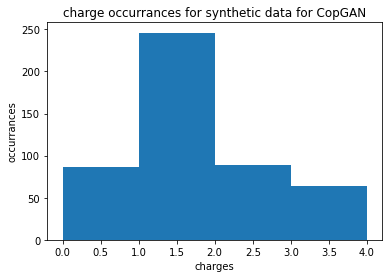

In [24]:
from matplotlib import pyplot as plt
#num_bins = 20
#group = [1000*i for i in range(13,65)]
#plt.hist(synth_data["charges"], group)
total01=len(synth_data["charges"])
ans01=[]
for i in range(0,65):
    num=len(synth_data["charges"][synth_data["charges"]==i])
    ans01.append(num/total01)
ans01=np.array(ans01)
print("The ratio of the synthetic data of charge >14000 is %.4f"%sum(ans01[14:]))
plt.title("charge occurrances for synthetic data for CopGAN")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(synth_data["charges"],bins=[i for i in range (5)])

The ratio of the original data of charge >14000 is 0.0000


(array([359., 633., 190., 156.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

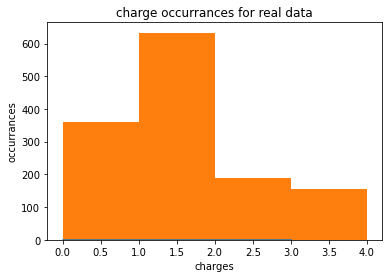

In [25]:
#plt.hist(ins_data["charges"][ins_data["charges"]>13000], group)
total02=len(ins_data["charges"])
ans02 = []
for i in range(4):
    num=len(ins_data["charges"][ins_data["charges"]==1])
    ans02.append(num/total02)
ans02=np.array(ans02)
print("The ratio of the original data of charge >14000 is %.4f"%sum(ans02[14:]))
plt.plot(range(4),ans02)
plt.title("charge occurrances for real data")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(ins_data["charges"],bins=[i for i in range (5)])

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [26]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = target, 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(       age        bmi  children  sex_female  smoker_no  region_northeast  \
 25    59.0  27.719999       3.0         1.0        1.0               0.0   
 336   60.0  25.740000       0.0         0.0        1.0               0.0   
 47    28.0  34.770000       0.0         1.0        1.0               0.0   
 106   19.0  28.400000       1.0         1.0        1.0               0.0   
 1269  45.0  27.500000       3.0         0.0        1.0               0.0   
 ...    ...        ...       ...         ...        ...               ...   
 595   44.0  22.249954       0.0         1.0        1.0               0.0   
 596   18.0  17.132633       1.0         1.0        1.0               1.0   
 597   21.0  31.425222       0.0         1.0        0.0               0.0   
 598   39.0  23.012075       5.0         1.0        0.0               0.0   
 599   18.0  27.614542       1.0         0.0        1.0               0.0   
 
       region_northwest  region_southeast  region_southwest  
 25         

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [27]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5640,0.0000,0.1703,0.5334,0.5376,0.3816,0.3899,0.7060
rf,Random Forest Classifier,0.5419,0.0000,0.1681,0.5034,0.5148,0.3429,0.3504,0.1510
lightgbm,Light Gradient Boosting Machine,0.5398,0.0000,0.1716,0.4959,0.5097,0.3387,0.3463,0.2870
lda,Linear Discriminant Analysis,0.5027,0.0000,0.1586,0.4594,0.4599,0.2925,0.3072,0.0130
et,Extra Trees Classifier,0.5013,0.0000,0.1526,0.4727,0.4810,0.2974,0.3022,0.1460
lr,Logistic Regression,0.5012,0.0000,0.1555,0.4617,0.4569,0.2771,0.2996,0.8520
knn,K Neighbors Classifier,0.4642,0.0000,0.1142,0.3758,0.4000,0.1957,0.2091,0.2730
ridge,Ridge Classifier,0.4635,0.0000,0.1273,0.4174,0.4070,0.1919,0.2231,0.0130
ada,Ada Boost Classifier,0.4591,0.0000,0.1161,0.3367,0.3651,0.2338,0.2571,0.0470
dt,Decision Tree Classifier,0.4471,0.0000,0.1425,0.4568,0.4469,0.2554,0.2570,0.0120


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=4029, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

In [28]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7589,0.0000,0.2183,0.7055,0.7245,0.6427,0.6532
1,0.6738,0.0000,0.1783,0.6598,0.6473,0.5172,0.5301
2,0.7214,0.0000,0.2460,0.6876,0.6833,0.5808,0.5976
3,0.7429,0.0000,0.2352,0.6980,0.7113,0.6214,0.6304
4,0.7429,0.0000,0.2777,0.7095,0.7151,0.6247,0.6319
5,0.6786,0.0000,0.2030,0.6240,0.6307,0.5101,0.5300
6,0.3714,0.0000,0.1157,0.3144,0.3312,0.1549,0.1595
7,0.3500,0.0000,0.0835,0.3381,0.3376,0.0883,0.0895
8,0.3214,0.0000,0.0819,0.3188,0.3178,0.0684,0.0689
9,0.2786,0.0000,0.0634,0.2780,0.2771,0.0074,0.0075


# **SECOND TRIAL**, NORMALIZED, CopulaGAN

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [29]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = CopulaGAN(constraints = [age_constraint, children_constraint])
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 5000)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_distributions()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.5338163169207376
2
0.5780131401669792
3
0.5089560727444589
4
0.5006251444761805
5
0.5479184793708861
6
0.540278238004119
7
0.5244448246222121
8
0.5674761823998982
9
0.5463877360332525
10
0.5250155476114958
11
0.5572682145823508
12
0.5294715482820707
13
0.5426230465353831
14
0.5734515350364329
15
0.5812717428775476
16
0.50989385385242
17
0.5573995112516141
18
0.5227848792823568
19
0.6165924225857959
20
0.48001360749763744
21
0.5805087110218649
22
0.4870826607258125
23
0.5985677592008017
24
0.5537973072700502
25
0.5398877562871638
26
0.5153811689556574
27
0.5017098818697954
28
0.501625897953
29
0.489312141889305
30
0.5589900958480789
time used: 20.875 mins


In [30]:
best_data

,age,sex,bmi,children,smoker,region,charges
0,61,male,25.306973,1,no,southeast,2
1,21,female,30.315801,1,no,southeast,1
2,64,female,33.789977,1,no,southeast,0
3,58,female,33.095561,1,no,northeast,1
4,62,male,25.595464,1,no,southwest,0
...,...,...,...,...,...,...,...
54,20,female,22.693628,0,yes,northwest,4
55,18,female,45.653916,2,no,northeast,1
56,59,male,30.223649,0,no,northwest,2
0,30,male,37.304297,2,no,southeast,1


In [31]:
best_distributions

{'age': 'copulas.univariate.beta.BetaUnivariate',
 'bmi': 'copulas.univariate.gamma.GammaUnivariate',
 'children': 'copulas.univariate.student_t.StudentTUnivariate',
 'charges': 'copulas.univariate.log_laplace.LogLaplace'}

(array([1238., 2562.,  671.,  360.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

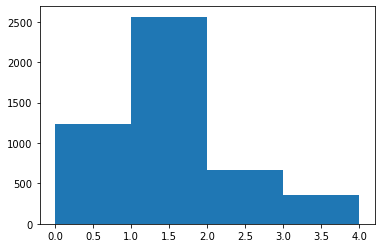

In [32]:
best=best_data
best_data=best_data[~best_data.index.duplicated()]
num_bins = 20
plt.hist(best_data["charges"], [i for i in range (5)])

In [33]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.740696,0.064525,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.800983,0.800983,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.336463,0.336463,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-142935.399790,0.000000,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.926508,0.926508,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.885591,0.885591,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.914347,0.914347,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.634797,0.634797,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.971152,0.971152,0.0,1.0,MAXIMIZE


In [34]:
synth=[]
for i in range (4):
    orig_size=len(train[train["charges"]==i])
    synth_part=best_data[best_data["charges"]==i]
    generate=synth_part.sample(n=min(max(0,350-orig_size),len(synth_part)))
    print(len(generate))
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

139
0
228
247


,age,sex,bmi,children,smoker,region,charges
1828,23,male,34.221832,4,yes,northwest,0
4907,59,female,32.387721,0,no,southwest,3
67,24,female,31.380121,1,yes,northwest,3
2696,28,male,32.849911,1,yes,southeast,2
2014,19,male,31.052319,1,yes,northeast,3
...,...,...,...,...,...,...,...
1279,34,female,30.194693,0,yes,northeast,2
3690,33,female,34.641156,2,yes,southwest,0
3837,20,male,25.504223,2,yes,southwest,0
2760,30,female,32.329044,3,yes,southwest,3


In [35]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

0.5354527011672857

In [36]:
print('Best score obtained: ', best_score)

Best score obtained:  0.6165924225857959


In [37]:
print(max(scores))
print(min(scores))

0.6165924225857959
0.48001360749763744


In [38]:
model.save('best_copula.pkl')

In [39]:
synth.to_csv("ins_synth_dat_norm_CGImb.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [40]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_dat_norm_CGImb.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [41]:
mixed

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720000,3,no,southeast,1
336,60,male,25.740000,0,no,southeast,1
47,28,female,34.770000,0,no,northwest,0
106,19,female,28.400000,1,no,southwest,0
1269,45,male,27.500000,3,no,southwest,1
...,...,...,...,...,...,...,...
609,23,female,24.357871,1,yes,northeast,3
610,38,female,32.473410,1,no,northeast,3
611,19,male,27.674644,2,no,northeast,3
612,41,male,34.783841,2,yes,southwest,3


In [42]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1416, 7)
Testing size (real: (536, 7)


Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [43]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(       age        bmi  children  sex_female  smoker_no  region_northeast  \
 25    59.0  27.719999       3.0         1.0        1.0               0.0   
 336   60.0  25.740000       0.0         0.0        1.0               0.0   
 47    28.0  34.770000       0.0         1.0        1.0               0.0   
 106   19.0  28.400000       1.0         1.0        1.0               0.0   
 1269  45.0  27.500000       3.0         0.0        1.0               0.0   
 ...    ...        ...       ...         ...        ...               ...   
 609   23.0  24.357872       1.0         1.0        0.0               1.0   
 610   38.0  32.473408       1.0         1.0        1.0               1.0   
 611   19.0  27.674644       2.0         0.0        1.0               1.0   
 612   41.0  34.783840       2.0         0.0        0.0               0.0   
 613   27.0  33.056499       2.0         0.0        1.0               0.0   
 
       region_northwest  region_southeast  region_southwest  
 25         

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [44]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5773,0.7587,0.5697,0.5581,0.5547,0.4340,0.4408,0.1490
lr,Logistic Regression,0.5696,0.7416,0.5604,0.5516,0.5351,0.4230,0.4351,0.6310
ridge,Ridge Classifier,0.5668,0.0000,0.5569,0.5531,0.5292,0.4188,0.4329,0.0120
lda,Linear Discriminant Analysis,0.5653,0.7416,0.5561,0.5507,0.5287,0.4173,0.4305,0.0120
ada,Ada Boost Classifier,0.5547,0.7322,0.5465,0.5446,0.5242,0.4037,0.4150,0.0380
rf,Random Forest Classifier,0.5484,0.7606,0.5413,0.5290,0.5315,0.3958,0.3992,0.1460
nb,Naive Bayes,0.5386,0.7515,0.5272,0.5207,0.4991,0.3804,0.3954,0.0140
lightgbm,Light Gradient Boosting Machine,0.5350,0.7458,0.5289,0.5202,0.5211,0.3783,0.3813,0.0850
et,Extra Trees Classifier,0.5096,0.7424,0.5030,0.4979,0.4980,0.3443,0.3469,0.1410
qda,Quadratic Discriminant Analysis,0.5012,0.7072,0.4908,0.4760,0.4665,0.3311,0.3421,0.0150


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1735, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

(array([350., 380., 350., 336.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

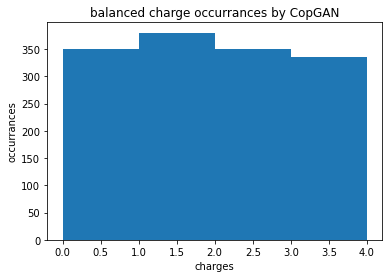

In [46]:

plt.title("balanced charge occurrances by CopGAN")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(mixed["charges"], [i for i in range (5)])

# **Finalising the model**
Now with the model trained and evaluated it needs to be **finalised**. This encorporates the test data into the model that will be used on unseen data.

# **SECOND TRIAL**, USE DIFFERENT DISTRIBUTION

(array([802.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
        18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000,
        36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000,
        54000, 56000, 58000, 60000, 62000, 64000]),
 <a list of 32 Patch objects>)

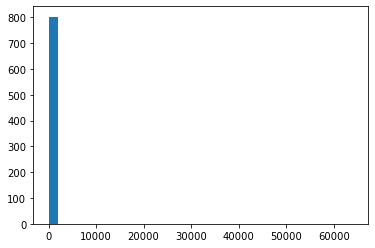

In [47]:
num_bins = 20
plt.hist(train["charges"], [2000*i for i in range (33)])

In [48]:
def MAXINT(a,b): return (abs(a-b)+(a+b))//2

def MAX(a,b): return (abs(a-b)+(a+b))/2

def MININT(a,b): return (-abs(a-b)+(a+b))//2

def MIN(a,b): return (-abs(a-b)+(a+b))/2

def over_18(data): return MAXINT(data["age"],18)

age_constraint = cons.ColumnFormula(column = 'age',
                                    formula = over_18,
                                    handling_strategy = 'reject_sampling')

def children_range(data): return MININT(MAXINT(data["children"],0),5)

children_constraint = cons.ColumnFormula(column = 'children',
                                         formula = children_range,
                                         handling_strategy = 'reject_sampling')

min_bmi = min(ins_data["bmi"])
max_bmi = max(ins_data["bmi"])
print(min_bmi,max_bmi)

def bmi_range(data): return MIN(MAX(data["bmi"],min_bmi),max_bmi)

bmi_constraint = cons.ColumnFormula(column = 'bmi',
                                    formula = bmi_range,
                                    handling_strategy = 'reject_sampling')

min_charges= min(ins_data["charges"])
max_charges = max(ins_data["charges"])
print(min_charges,max_charges)

def charges_range(data): return MIN(MAX(data["charges"],min_charges*0.8),max_charges*1.25)

charges_constraint = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range,
                                    handling_strategy = 'reject_sampling')

def charges_range_truncated(data): return MIN(MAX(data["charges"],12000),max_charges*1.25)

charges_constraint_2 = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range_truncated,
                                    handling_strategy = 'reject_sampling')

15.96 53.13
0 3


With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [ ]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(100): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = CopulaGAN(constraints = [age_constraint, children_constraint, bmi_constraint],
                           field_transformers = {k:"categorical_fuzzy" for k in ["sex", "smoker", "region"]})
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 600)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_distributions()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.46511505656976077
2


In [ ]:
best_data

In [ ]:
best_distributions

In [ ]:
best=best_data
best_data=best_data[~best_data.index.duplicated()]
num_bins = 20
plt.hist(best_data["charges"], [2000*i for i in range (33)])

In [ ]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

In [ ]:
synth=[]
for i in range (6,32):
    orig_size=len(train[train["charges"]<(i+1)*2000][train["charges"]>(i)*2000])
    synth_part=best_data[best_data["charges"]<(i+1)*2000][best_data["charges"]>(i)*2000]
    generate=synth_part[:100-orig_size]
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

In [ ]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

In [ ]:
print('Best score obtained: ', best_score)

In [ ]:
print(max(scores))
print(min(scores))

In [ ]:
model.save('best_copula.pkl')

In [ ]:
synth.to_csv("ins_synth_dat_univariate.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [ ]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_dat_univariate.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [ ]:
mixed

In [ ]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

In [ ]:
#plt.hist(synth_data["charges"], group)
total=len(mixed["charges"])
plt.title("charge occurrances for synthetic data for univariate distribution")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(mixed["charges"], [1000*i for i in range (65)])

In [ ]:
#plt.hist(ins_data["charges"][ins_data["charges"]>13000], group)
total2=len(ins_data["charges"][ins_data["charges"]>13000])
ans2 = []
for i in range(14,65):
    num=len(ins_data["charges"][ins_data["charges"]<(i+1)*1000][ins_data["charges"]>=i*1000])
    ans2.append(num/total)
ans2=np.array(ans2)
plt.plot(range(14,65),ans2)
plt.show()

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [ ]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [ ]:
compare_models()

A gradient boosting classifier was decided upon.

In [ ]:
par = create_model("par")

# **Finalising the model**
Now with the model trained and evaluated it needs to be **finalised**. This encorporates the test data into the model that will be used on unseen data.

In [ ]:
final_gbc = finalize_model(huber)

In [ ]:
final_gbc = finalize_model(huber)

**NOTE**: I haven't further explored the model e.g. feature importance as the purpose of this project was to focus on synthetic data generation and a streamlit app.

# **Saving and exporting ready for app build**
To use the model in a `streamlit` app certain things need to be exported
* The model
* Preprocessed data
* Preparation steps (`prep pipe`)

In [ ]:
# Model (save)
save_model(final_gbc, "final_gbc")

# Preparation steps (get + save)
prep = get_config("prep_pipe")
joblib.dump(prep, 'prep_pipe.pkl', compress = 1)

# Preprocessed data (get + save)
get_config("X").to_csv("preprocssed_data.csv", index = False)

# **Streamlit app**
The final output of this was a `streamlit` app to allow single predictions w/reason plots or multi predictions from an uploaded csv (see `README.md` and `app.py`).

# **Conclusion**
I think that synthetic data generation can be a powerful tool especially in situations when further data collection cannot be performed in the near term. Fine tuning hyperparameters is great to have but more data and feature engineering are still superior.

In [ ]:
# any random test
import random
# give a data of 20% 0-100, 40% 100-200, 30% 200-300,10% 300-400, 
small=[[100*random.random()] for _ in range (400)]
medium=[[100+100*random.random()] for _ in range (800)]
large=[[200+100*random.random()] for _ in range (600)]
extralarge=[[300+100*random.random()] for _ in range (200)]
mix=small+medium+large+extralarge
random.shuffle(mix)
df = pd.DataFrame(mix, columns=["s"])
final_ans=[]
for _ in range (200):
    toy_ans = list()
    model = GaussianCopula()
    model.fit(df)
    synth = model.sample(num_rows = 2000)
    for i in range(4):
        num=len(synth["s"][synth["s"]<(i+1)*100][synth["s"]>=i*100])
        toy_ans.append(num/2000)
    final_ans.append(toy_ans)
final_ans

In [ ]:
plt.hist(np.array(mix),bins=np.array([10*i for i in range(41)]))

In [ ]:
arr=np.array(final_ans)
trans_arr=np.transpose(arr)
plt.hist(trans_arr[3],bins=np.array([i/500 for i in range (38,55)]))

In [ ]:
plt.hist(trans_arr[2],bins=np.array([i/500 for i in range (140,169)]))

In [ ]:
plt.hist(trans_arr[1],bins=np.array([i/500 for i in range (179,207)]))

In [ ]:
plt.hist(trans_arr[0],bins=np.array([i/500 for i in range (75,99)]))